# Creating the Database
* In order to create the database, please ensure `sqlalchemy_utils` and `psycopg2` has been installed in your local machine.

In [1]:
# Import for creating a new database
# Note: make sure to install sqlalchemy_utils and psycopg2
from sqlalchemy_utils import database_exists, create_database
from sqlalchemy import create_engine
# Import classes to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float, LargeBinary
# Import Base for which classes will be constructed 
from sqlalchemy.ext.declarative import declarative_base

* Please change `owner_username` and `password` accordingly, based on your database setup information.

In [2]:
# Creating the database

owner_username = 'postgres'
password = 'jacky%402023'
host_name_address = 'localhost'

engine = create_engine(f"postgresql://{owner_username}:{password}@{host_name_address}/project4_db")

if not database_exists(engine.url):
    create_database(engine.url)

if database_exists(engine.url):
    print('Database was created successfully!')
else:
    print('Something went wrong.')

Database was created successfully!


In [3]:
# Declare classes that will become the tables
Base = declarative_base()

# Create the Contacts class
class TrainImages(Base):
    __tablename__ = 'trainimages'
    image_id = Column(Integer, primary_key=True)
    file_name = Column(String)
    image_content = Column(LargeBinary)

class PriceTable(Base):
    __tablename__ = 'pricetable'
    id = Column(Integer, primary_key=True)
    Brand = Column(String)
    Category = Column(String)
    Color = Column(String)
    Size = Column(String)
    Material = Column(String)
    Price = Column(Float)

In [4]:
# Create tables
Base.metadata.create_all(engine)

# Retrieving Data from S3 Bucket
* We use `AWS command line interface (CLI)` to retrieving data from S3. In order to run AWS CLI, please ensure `AWS CLI` is install. If not, please refer to below link:
https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html
* After installation, please run `aws configure` command in command prompt window, and setup the configuration: <br>
`Access key ID` = Please request for access <br>
`Secret access key` = Please request for access <br>
`Region name` = us-east-1


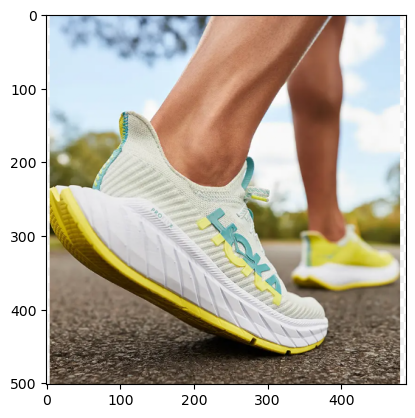

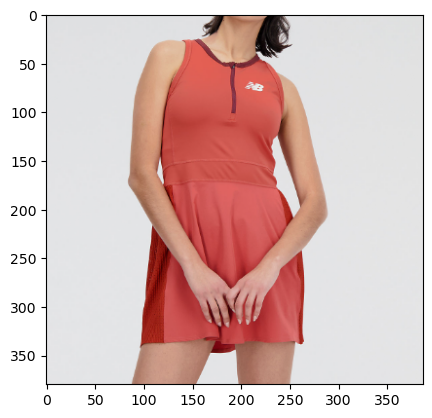

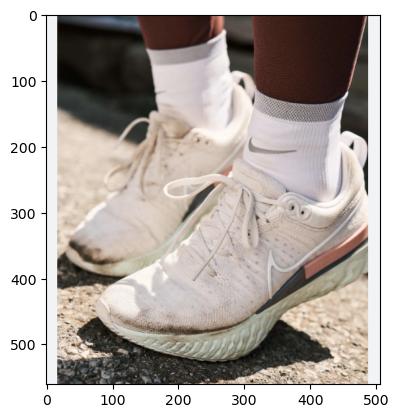

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
from io import BytesIO

# Create an S3 client
s3 = boto3.client('s3', region_name='us-east-1')

# Specify the bucket name and folder path
bucket_name = 'bootcampproject4'
folder_path = 'Project4Images/'  # Include the trailing slash

# List objects in the specified folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)
# print(response)

# Create a list to store the images
images = []

# Retrieve each image from S3 and store in the list
if 'Contents' in response:
    for obj in response['Contents']:
        object_key = obj['Key']
        # Skip folders and non-image files
        if object_key.endswith('.PNG') or object_key.endswith('.jpg') or object_key.endswith('.jpeg'):
            response = s3.get_object(Bucket=bucket_name, Key=object_key)
            image_content = response['Body'].read()
            image_bytesio = BytesIO(image_content)
            img = mpimg.imread(image_bytesio)
            images.append(img)

# Display the loaded images
for img in images:
    imgplot = plt.imshow(img)
    plt.show()
#------------------------------------------------------------------------------------------------------------
#---------------all images in the folder are now in the images list.-------------------------------------------------------   
#------------------------------------------------------------------------------------------------------------


In [6]:
    
import pandas as pd

# Specify the bucket and file key (path)
bucket_name = 'bootcampproject4'
file_key = 'TxtFolder/clothes_price_prediction_data.csv'

# Read the CSV file from S3 using pandas
try:
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    df = pd.read_csv(response['Body'])

    print(df.head())  # Display the first few rows of the DataFrame

except Exception as e:
    print(f"Error reading CSV file from S3: {e}")

#------------------------------------------------------------------------------------------------------------
#---------------price raw material(csv) is now in the df.---------------------------------------------------- 
#------------------------------------------------------------------------------------------------------------
    


          Brand Category  Color Size Material  Price
0   New Balance    Dress  White   XS    Nylon    182
1   New Balance    Jeans  Black   XS     Silk     57
2  Under Armour    Dress    Red    M     Wool    127
3          Nike    Shoes  Green    M   Cotton     77
4        Adidas  Sweater  White    M    Nylon    113


# Load Data to Database

In [7]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import delete

# Create a session maker
Session = sessionmaker(bind=engine)

# Create a session
session = Session()

# Clear the TrainImages table
session.execute(delete(TrainImages))

# Commit the deletion
session.commit()

# Loop over each image loaded from S3
for idx, img in enumerate(images):
    # Generate a unique file name
    file_name = f'image_{idx}.png'

    # Convert image to bytes
    with BytesIO() as output:
        plt.imsave(output, img, format='png')
        image_data = output.getvalue()

    # Create a new TrainImages instance and set its attributes
    image_instance = TrainImages(file_name=file_name, image_content=image_data)

    # Add the instance to the session
    session.add(image_instance)

# Commit the changes to the database
session.commit()

# Query all records from the TrainImages table and print file names
train_images = session.query(TrainImages).all()
for image in train_images:
    print(image.file_name)

# Close the session
session.close()

image_0.png
image_1.png
image_2.png


In [8]:
# Define function to add df to database table
# How to use method:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
def add_df_to_db(table_name, df):
    engine.execute(f"DELETE FROM {table_name}")

    rows_added = df.to_sql(table_name, engine, if_exists='append', index=False)

    print(f"{rows_added} rows were added successfully to {table_name} table.")



# Add contacts df to database
add_df_to_db('pricetable', df)

1000 rows were added successfully to pricetable table.


# Read Data from Database

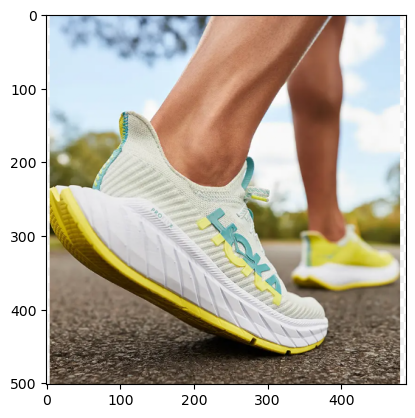

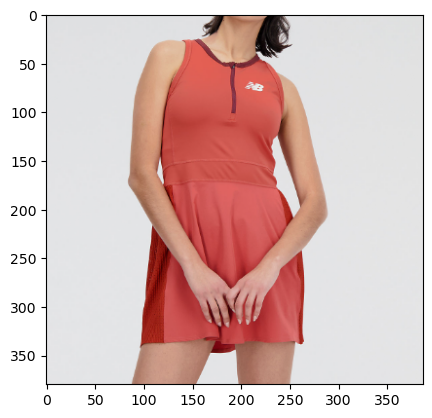

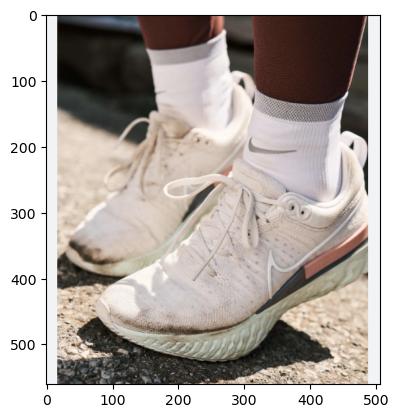

In [9]:
import numpy as np

# Database connection parameters
owner_username = 'postgres'
password = 'jacky%402023'
host_name_address = 'localhost'
database_name = 'project4_db'

# Creating the engine
engine = create_engine(f"postgresql://{owner_username}:{password}@{host_name_address}/{database_name}")

# Create a session maker
Session = sessionmaker(bind=engine)

# Create a session
session = Session()

# Query all records from the TrainImages table
train_images = session.query(TrainImages).all()

# Container to store the retrieved images
images_retrieved = []

# Loop through retrieved images
for image in train_images:
    # Convert the image content from bytes to numpy array
    image_data = np.frombuffer(image.image_content, dtype=np.uint8)
    
    # Reconstruct the image using Matplotlib
    img = plt.imread(BytesIO(image_data), format='png')

    images_retrieved.append(img)

    # # Display the image
    # plt.imshow(img)
    # plt.title(image.file_name)
    # plt.show()

for img in images_retrieved:
    imgplot = plt.imshow(img)
    plt.show()

# Close the session
session.close()


In [10]:
# Database connection parameters
owner_username = 'postgres'
password = 'jacky%402023'
host_name_address = 'localhost'
database_name = 'project4_db'

# Creating the engine
engine = create_engine(f"postgresql://{owner_username}:{password}@{host_name_address}/{database_name}")

# Create a session maker
Session = sessionmaker(bind=engine)

# Create a session
session = Session()

# Query all records from the PriceTable table
price_data = session.query(PriceTable).all()

df = pd.DataFrame([{
    'ID': record.id,
    'Brand': record.Brand,
    'Category': record.Category,
    'Color': record.Color,
    'Size': record.Size,
    'Material': record.Material,
    'Price': record.Price
} for record in price_data])

# Close the session
session.close()

df

,ID,Brand,Category,Color,Size,Material,Price
0,3001,New Balance,Dress,White,XS,Nylon,182.0
1,3002,New Balance,Jeans,Black,XS,Silk,57.0
2,3003,Under Armour,Dress,Red,M,Wool,127.0
3,3004,Nike,Shoes,Green,M,Cotton,77.0
4,3005,Adidas,Sweater,White,M,Nylon,113.0
...,...,...,...,...,...,...,...
995,3996,Puma,Jeans,Black,L,Polyester,176.0
996,3997,Puma,Jacket,Red,XXL,Silk,110.0
997,3998,Reebok,Sweater,Blue,XS,Denim,127.0
998,3999,Under Armour,Sweater,Black,XXL,Denim,69.0
